In [104]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
import joblib

In [2]:
def data_extract_class(data_file):
    """
    :param data_file:   csv file containing light sequences, heavy sequences and their tm50 values.
    :return:            lists of light sequences, heavy sequences and tm50 values.
    """

    df = pd.read_csv(data_file)
    df.rename(columns={'VL': 'Light'}, inplace=True)
    df.rename(columns={'VH': 'Heavy'}, inplace=True)
    df.rename(columns={"Fab Tm by DSF (°C)": 'Temp'}, inplace=True)

    light_seq = df['Light'].values.tolist()
    heavy_seq = df['Heavy'].values.tolist()
    temp = df['Temp'].values.tolist()
    bin = df['bin'].values.tolist()


    return light_seq, heavy_seq, temp, bin

In [3]:
bert_data_60 = "../data/combined_datasets_60.csv"
df = pd.read_csv(bert_data_60)

light, heavy, temp, bin = data_extract_class('../data/combined_datasets_class.csv')

X = df
y = bin

In [14]:
from sklearn.metrics import matthews_corrcoef


def rnn_cv(X,y, num_epochs=100, batch_size=10):

    sns.set_style(style='white')

    rand = 28

    y = pd.DataFrame(y)
    y = y.values.ravel()

    X.columns = ['{}'.format(i) for i in range(len(X.columns))]

    # set up train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand)

    y_test=np.argmax(y_test)


    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
    axs = axs.flatten()

    mae_scores = []
    r2_scores = []
    pearsonr_scores = []

    # set up the k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    best_model = None
    best_score = -np.inf

    for i, (train_index, val_index) in enumerate(kf.split(X_train)):

        k_X_train, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        k_y_train, y_val = y_train[train_index], y_train[val_index]

        # create the RNN model
        k_X_train = k_X_train.values.reshape((k_X_train.shape[0], k_X_train.shape[1], 1))
        X_val = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
        k_y_train = np.array(k_y_train)
        y_val = np.array(y_val)
        model = Sequential()
        model.add(LSTM(100, input_shape=(k_X_train.shape[1], k_X_train.shape[2])))
        model.add(Dense(1, activation ='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')

        # fit the model
        history = model.fit(k_X_train, k_y_train, epochs=num_epochs, batch_size=batch_size, verbose=2, validation_data=
        (X_val, y_val))

        # evaluate the model on the test set
        y_pred = np.argmax(model.predict(X_test))
        MCC = matthews_corrcoef(y_test, y_pred)

        # save the best model
        if MCC > best_score:
            best_score = MCC
            best_model = model



        # plot training and validation loss on the appropriate subplot
        axs[i].plot(history.history['loss'])
        axs[i].plot(history.history['val_loss'])
        axs[i].set_title(f'Fold {i+1} Loss')
        axs[i].set_ylabel('Loss')
        axs[i].set_xlabel('Epoch')
        axs[i].legend(['Train', 'Validation'], loc='upper right')

    # adjust the layout and display the plots
    plt.tight_layout()
    plt.show()
    print (best_score)


    return best_model

Epoch 1/100
13/13 - 2s - loss: 0.4367 - val_loss: 0.6325 - 2s/epoch - 136ms/step
Epoch 2/100
13/13 - 0s - loss: 0.2218 - val_loss: 0.6709 - 163ms/epoch - 13ms/step
Epoch 3/100
13/13 - 0s - loss: 0.2049 - val_loss: 0.7215 - 136ms/epoch - 10ms/step
Epoch 4/100
13/13 - 0s - loss: 0.1415 - val_loss: 0.6830 - 134ms/epoch - 10ms/step
Epoch 5/100
13/13 - 0s - loss: 0.1123 - val_loss: 0.6806 - 149ms/epoch - 11ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0800 - val_loss: 0.6871 - 158ms/epoch - 12ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0539 - val_loss: 0.7111 - 153ms/epoch - 12ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0268 - val_loss: 0.7111 - 150ms/epoch - 12ms/step
Epoch 9/100
13/13 - 0s - loss: -8.7944e-03 - val_loss: 0.7176 - 142ms/epoch - 11ms/step
Epoch 10/100
13/13 - 0s - loss: -4.3909e-02 - val_loss: 0.7508 - 133ms/epoch - 10ms/step
Epoch 11/100
13/13 - 0s - loss: -7.1183e-02 - val_loss: 0.7014 - 129ms/epoch - 10ms/step
Epoch 12/100
13/13 - 0s - loss: -1.3200e-01 - val_loss: 0.7610 - 145ms/e

TypeError: Singleton array 5 cannot be considered a valid collection.

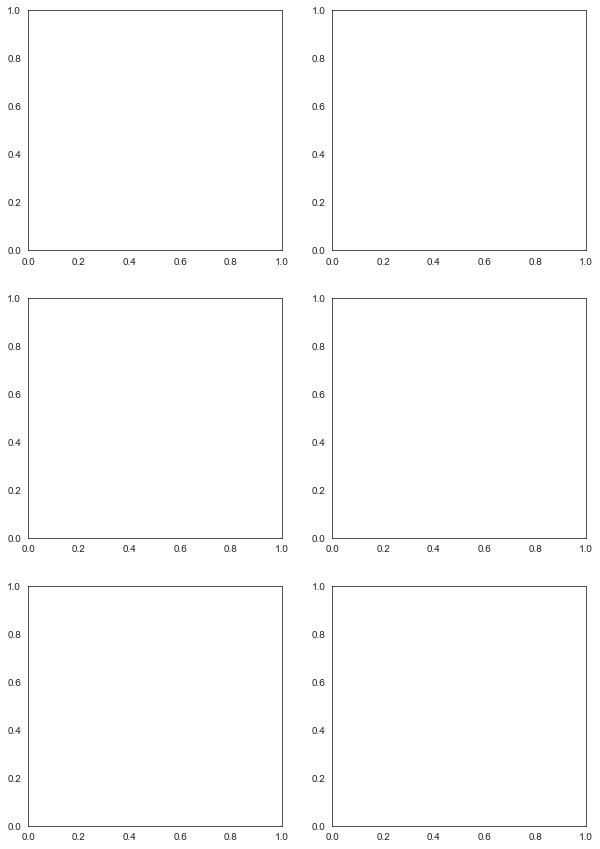

In [15]:
model = rnn_cv(X,y)

In [67]:
def rnn_cv(X,y, num_epochs=100, batch_size=10):

    sns.set_style(style='white')

    rand = 28

    y = pd.DataFrame(y)
    y = y.values.ravel()

    X.columns = ['{}'.format(i) for i in range(len(X.columns))]

    # set up train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand)

    X_test = np.array(X_test)
    y_test=np.array(y_test)


    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
    axs = axs.flatten()
    X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1],1))
    y_train = np.array(y_train)

    print (type(X_train))
    print (type(y_train))
    print (type(X_test))
    print (type(y_test))

    model = Sequential()
    model.add(LSTM(100))
    model.add(Dense(3, activation ='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    # fit the model
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)

    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

     # evaluate the model on the test set
    y_pred = model.predict(X_test)
    #MCC = matthews_corrcoef(y_test, y_pred)

    print (y_pred)
    print (y_test)


    #print (MCC)


    return model

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/100


ValueError: in user code:

    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\toon_\.virtualenvs\AntibodyFvTm50Predictor\lib\site-packages\keras\backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


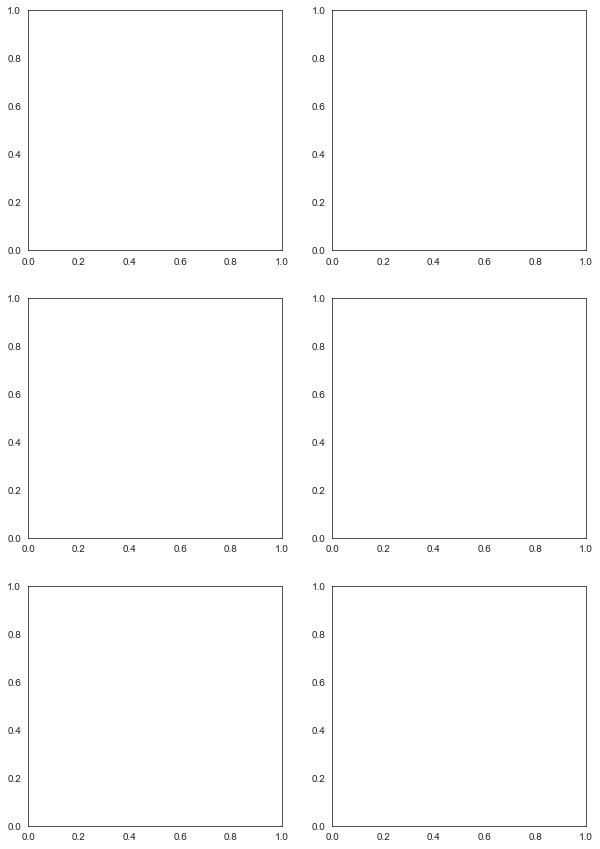

In [68]:
model = rnn_cv(X,y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [35]:
X_train.shape

(159, 60)

In [36]:
X_train_r = X_train.values.reshape(1,(X_train.shape[0], X_train.shape[1]))

TypeError: 'tuple' object cannot be interpreted as an integer

In [38]:
X_train.values.shape

(159, 60)

In [39]:
a = X_train.values.reshape((X_train.shape[0], X_train.shape[1]),1)

TypeError: 'tuple' object cannot be interpreted as an integer

In [42]:
X_train.shape[1]

60

In [99]:
from keras.initializers import glorot_uniform

def rnn_cv(X, y, num_epochs=100, batch_size=10):
    sns.set_style(style='white')
    rand = 28

    y = pd.DataFrame(y)
    y = y.values.ravel()

    X.columns = ['{}'.format(i) for i in range(len(X.columns))]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand)

    X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Convert labels to one-hot encoded format
    y_train_encoded = to_categorical(y_train, num_classes=3)
    y_test_encoded = to_categorical(y_test, num_classes=3)

    model = Sequential()
    model.add(LSTM(100, kernel_initializer=glorot_uniform(seed=rand)))
    model.add(Dense(3, activation='softmax', kernel_initializer=glorot_uniform(seed=rand)))  # Softmax for multi-class
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    history = model.fit(X_train, y_train_encoded, epochs=num_epochs, batch_size=batch_size)

    scores = model.evaluate(X_test, y_test_encoded, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1] * 100))

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(y_pred_classes)
    print(y_test)

    #MCC evaluation
    MCC = matthews_corrcoef(y_test, y_pred_classes)
    print (MCC)

    target_names = ['<70', '70 - 75', '>75']
    print(classification_report(y_test, y_pred_classes, target_names=target_names))


    return model

In [102]:
rnn_cv(X,y)

Epoch 1/100
16/16 [==============================] - 1s 8ms/step - loss: 1.1761 - categorical_accuracy: 0.2579
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0464 - categorical_accuracy: 0.4591
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0259 - categorical_accuracy: 0.5094
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0034 - categorical_accuracy: 0.5157
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9852 - categorical_accuracy: 0.5220
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9666 - categorical_accuracy: 0.5346
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9431 - categorical_accuracy: 0.5975
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9297 - categorical_accuracy: 0.5535
Epoch 9/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9063 - categorical_accuracy: 0.6164
E

In [105]:
joblib.dump(model, '../models/24082023_rnn_classification_model.joblib')

INFO:tensorflow:Assets written to: ram://4da1a42a-ecb6-4a34-929f-e995b5ea5a40/assets


INFO:tensorflow:Assets written to: ram://4da1a42a-ecb6-4a34-929f-e995b5ea5a40/assets


['../models/24082023_rnn_classification_model.joblib']